In [25]:
import os
import sys
import numpy as np
import pandas as pd
from copy import deepcopy
from tqdm import tqdm

import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import torch
from kan import KAN

from tqdm import tqdm

In [26]:
from raw_data_processing import get_x, get_y, get_wavelength
from tools import JSON_Read, plotly_multi_scatter, get_all_sqz_input, KAN_es

In [27]:
SCRIPT_DIR = os.path.abspath('')

## Loading data

In [28]:
d_config = JSON_Read("", "json_config.txt")

EXCITE_WAVE_LENGTH = d_config['EXCITE_WAVE_LENGTH']
PREDICT_IONS = 'NO3'#d_config['PREDICT_IONS']
SPEC_FOLDER = d_config['SPEC_FOLDER']

TRAIN_TEST_RATIO = d_config['TRAIN_TEST_RATIO']
VALIDATION_TRAIN_RATIO = d_config['VALIDATION_TRAIN_RATIO']
N_ITER_NO_CHANGE = d_config['N_ITER_NO_CHANGE'] # For KAN

HIDDEN_LAYER_SIZES = d_config['HIDDEN_LAYER_SIZES']
ACTIVATION = d_config['ACTIVATION']
SOLVER = d_config['SOLVER']
MAX_ITER = d_config['MAX_ITER'] # Upper bound of number of iterationd. For MLP
TOL = d_config['TOL']

d_config

{'SPEC_FOLDER': 'full_data',
 'EXCITE_WAVE_LENGTH': 350,
 'PREDICT_IONS': ['Cr'],
 'TRAIN_TEST_RATIO': 0.9,
 'VALIDATION_TRAIN_RATIO': 0.222,
 'RANDOM_STATE_SPLIT': 42,
 'N_ITER_NO_CHANGE': 100,
 'HIDDEN_LAYER_SIZES': 64,
 'RANDOM_STATE_TRAIN': 42,
 'ACTIVATION': 'tanh',
 'SOLVER': 'adam',
 'EARLY_STOPPING': True,
 'MAX_ITER': 10000,
 'TOL': 0.001}

In [29]:
x = get_x(wave_length=EXCITE_WAVE_LENGTH, spec_file=""+SPEC_FOLDER)
y = get_y(l_ions=PREDICT_IONS, spec_file=""+SPEC_FOLDER)

In [30]:
y

array([ 0.  ,  1.65,  3.3 ,  4.95,  6.6 ,  8.25,  9.9 , 11.55, 13.2 ,
       14.85,  1.1 ,  2.75,  4.4 ,  6.05,  7.7 ,  9.35, 11.  , 12.65,
       14.3 , 15.95,  2.2 ,  3.85,  5.5 ,  7.15,  8.8 , 10.45, 12.1 ,
       13.75, 15.4 , 17.05,  3.3 ,  4.95,  6.6 ,  8.25,  9.9 , 11.55,
       13.2 , 14.85, 16.5 , 18.15,  4.4 ,  6.05,  7.7 ,  9.35, 11.  ,
       12.65, 14.3 , 15.95, 17.6 , 19.25,  5.5 ,  7.15,  8.8 , 10.45,
       12.1 , 13.75, 15.4 , 17.05, 18.7 , 20.35,  6.6 ,  8.25,  9.9 ,
       11.55, 13.2 , 14.85, 16.5 , 18.15, 19.8 , 21.45,  7.7 ,  9.35,
       11.  , 12.65, 14.3 , 15.95, 17.6 , 19.25, 20.9 , 22.55,  8.8 ,
       10.45, 12.1 , 13.75, 15.4 , 17.05, 18.7 , 20.35, 22.  , 23.65,
        9.9 , 11.55, 13.2 , 14.85, 16.5 , 18.15, 19.8 , 21.45, 23.1 ,
       24.75,  1.1 ,  2.75,  4.4 ,  6.05,  7.7 ,  9.35, 11.  , 12.65,
       14.3 , 15.95,  2.2 ,  3.85,  5.5 ,  7.15,  8.8 , 10.45, 12.1 ,
       13.75, 15.4 , 17.05,  3.3 ,  4.95,  6.6 ,  8.25,  9.9 , 11.55,
       13.2 , 14.85,

# Squeeze input data

In [31]:
l_wavelenth = get_wavelength(spec_file=""+SPEC_FOLDER)

In [32]:
x_matrix, y_matrix = np.broadcast_to(l_wavelenth, (len(x), len(l_wavelenth))), x.to_numpy()

x_sqz = get_all_sqz_input(x_matrix, y_matrix)

In [33]:
def alg_KAN_es(x, y, seed = None, num_hn=1,
               K=3, GRID = 3,
               lamb=0., lamb_l1=1., lamb_entropy=2.,
               steps=200, tol=0.001, n_iter_no_change=10):
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                        train_size=TRAIN_TEST_RATIO,
                                                        random_state=seed)

    x_val, x_train, y_val, y_train = train_test_split(x_train, y_train, 
                                                      train_size=VALIDATION_TRAIN_RATIO, 
                                                      random_state=seed)
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_val = scaler.transform(x_val)
    x_test = scaler.transform(x_test)

    tc_x_train = torch.from_numpy(x_train)
    tc_y_train = torch.from_numpy(y_train.reshape([-1,1]))
    tc_x_val = torch.from_numpy(x_val)
    tc_y_val = torch.from_numpy(y_val).reshape([-1,1])
    tc_x_test = torch.from_numpy(x_test)
    tc_y_test = torch.from_numpy(y_test).reshape([-1,1])

    dataset_3 = {'train_input': tc_x_train,
                 'train_label': tc_y_train,
                 'val_input': tc_x_val,
                 'val_label': tc_y_val,
                 'test_input': tc_x_test,
                 'test_label': tc_y_test}
    
    INPUT_SHAPE = tc_x_test.shape[1]

    model_es = KAN_es(width=[INPUT_SHAPE, num_hn, 1], grid=GRID, k=K, seed=seed)
    result_es = model_es.train_es(dataset_3, 
                                  tol=tol, 
                                  n_iter_no_change=n_iter_no_change,
                                  opt="LBFGS", steps=steps, 
                                  lamb=lamb,
                                  lamb_l1=lamb_l1,
                                  lamb_entropy=lamb_entropy
                                  )
    
    pred_test = model_es(dataset_3['test_input']).cpu().detach().numpy().ravel()
    rmse = mean_squared_error(y_test, pred_test)
    r2 = r2_score(y_test, pred_test)
    mae = mean_absolute_error(y_test, pred_test)

    return [rmse, r2, mae]

In [34]:
def alg_skl_model(x, y, class_model, model_kwargs, seed = None):
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                        train_size=TRAIN_TEST_RATIO,
                                                        random_state=seed)
    
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    #print(model_kwargs)
    model = class_model(random_state=seed, **model_kwargs)
    model.fit(x_train, y_train)

    pred_test = model.predict(x_test)
    rmse = mean_squared_error(y_test, pred_test)
    r2 = r2_score(y_test, pred_test)
    mae = mean_absolute_error(y_test, pred_test)

    return [rmse, r2, mae]

In [35]:
MLP_model_kwargs = {'hidden_layer_sizes': HIDDEN_LAYER_SIZES,
                  'activation': ACTIVATION,
                  'solver': SOLVER,
                  'early_stopping': True,
                  'validation_fraction': VALIDATION_TRAIN_RATIO,
                  'n_iter_no_change': N_ITER_NO_CHANGE,
                  'learning_rate_init': 0.001,
                  'learning_rate': 'adaptive',
                  'max_iter': MAX_ITER,
                  'tol': TOL}

GB_model_kwargs = {'validation_fraction': VALIDATION_TRAIN_RATIO,
                   'n_iter_no_change': N_ITER_NO_CHANGE}

RF_model_kwargs = {}

In [36]:
MLP_model_kwargs

{'hidden_layer_sizes': 64,
 'activation': 'tanh',
 'solver': 'adam',
 'early_stopping': True,
 'validation_fraction': 0.222,
 'n_iter_no_change': 100,
 'learning_rate_init': 0.001,
 'learning_rate': 'adaptive',
 'max_iter': 10000,
 'tol': 0.001}

# ---Debugging---

In [37]:
def scatter_prediction(model, 
                       x, 
                       y_true, 
                       title = ""):
    """Evaluates MSE and R^2 of model. 
    Draws scatter plot of (y_true, y_predicted).
    Returns  (mse, r2)
    """
    y_pred = model.predict(x)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    fig, ax = plt.subplots(figsize=(5,5))
    plt.plot(y_true, y_pred, 'o', markersize=2, alpha = 0.2) 
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], markersize=2, alpha = 0.5, color='r') 
    ax.set_title(f"MSE={round(mse, 5)} | RMSE={round(mse**0.5, 5)} | R2={round(r2, 5)} | {title}")
    ax.set_xlabel("y_true")
    ax.set_ylabel("y_pred")
    plt.show()
    
    return mse, r2

In [38]:
def alg_skl_model_dbg(x, y, class_model, model_kwargs, seed = None):

    print('x shape:', x.shape)
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                        train_size=TRAIN_TEST_RATIO,
                                                        random_state=seed)
    
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    #print(model_kwargs)
    model = class_model(random_state=seed, **model_kwargs)
    model.fit(x_train, y_train)

    pred_test = model.predict(x_test)
    rmse = mean_squared_error(y_test, pred_test)
    r2 = r2_score(y_test, pred_test)
    mae = mean_absolute_error(y_test, pred_test)

    scatter_prediction(model, x_train, y_train, 'train')
    scatter_prediction(model, x_test, y_test, 'test')

    print(model.get_params())
    #print(model.get_metadata_routing())

    return [rmse, r2, mae]

x shape: (1000, 5)


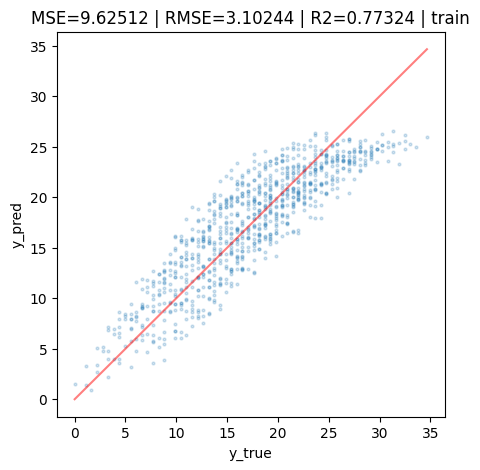

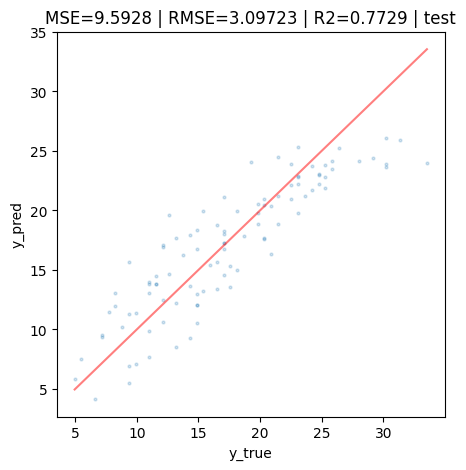

{'activation': 'tanh', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': True, 'epsilon': 1e-08, 'hidden_layer_sizes': 64, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 10000, 'momentum': 0.9, 'n_iter_no_change': 100, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.001, 'validation_fraction': 0.222, 'verbose': False, 'warm_start': False}


[9.592804915962812, 0.7729001095812325, 2.5544685380590106]

In [39]:
alg_skl_model_dbg(x_sqz, y, MLPRegressor, MLP_model_kwargs)

# ------

In [40]:
def multi_exp(l_algos_names,
              l_algos,
              mult_X_Y,
              l_kwargs,
              l_metrics_names,
              num_iter):
    ''' Function, that process algos(X, Y) and returns df of their metrics. 
    '''
    res_list = []

    for alg, (x, y), kwargs, alg_name in zip(l_algos, mult_X_Y, l_kwargs, l_algos_names):
        print(f'--- Processing {alg_name}')

        for i in range(1, num_iter+1):
            print(f'iter: {i}')
            #print(kwargs)
            l_metrics = alg(x, y, seed=i, **kwargs)
            res_list.append([alg_name, i]+l_metrics)
        print('-------')

    return pd.DataFrame(res_list, columns=['alg_name', 'iter']+l_metrics_names)

In [41]:
l_algos_names=['500_KAN', '500_MLP', '500_RF', '500_GB',
               '5_KAN', '5_MLP', '5_RF', '5_GB']

l_algos=[alg_KAN_es, alg_skl_model, alg_skl_model, alg_skl_model,
         alg_KAN_es, alg_skl_model, alg_skl_model, alg_skl_model]

mult_X_Y=[(x, y), (x, y), (x, y), (x, y), 
          (x_sqz, y), (x_sqz, y), (x_sqz, y), (x_sqz, y)]

l_kwargs=[{},
          {'class_model': MLPRegressor,'model_kwargs': MLP_model_kwargs},
          {'class_model': RandomForestRegressor,'model_kwargs': RF_model_kwargs},
          {'class_model': GradientBoostingRegressor,'model_kwargs': GB_model_kwargs},
          {},
          {'class_model': MLPRegressor,'model_kwargs': MLP_model_kwargs},
          {'class_model': RandomForestRegressor,'model_kwargs': RF_model_kwargs},
          {'class_model': GradientBoostingRegressor,'model_kwargs': GB_model_kwargs},]

l_metrics_names=['rmse', 'r2', 'mae']

num_iter=100

In [42]:
'''
l_algos_names=['500_MLP', '500_RF', '500_GB',
               '5_MLP', '5_RF', '5_GB']

l_algos=[alg_skl_model, alg_skl_model, alg_skl_model,
         alg_skl_model, alg_skl_model, alg_skl_model]

mult_X_Y=[(x, y), (x, y), (x, y), 
          (x_sqz, y), (x_sqz, y), (x_sqz, y)]

l_kwargs=[{'class_model': MLPRegressor,'model_kwargs': MLP_model_kwargs},
          {'class_model': RandomForestRegressor,'model_kwargs': RF_model_kwargs},
          {'class_model': GradientBoostingRegressor,'model_kwargs': GB_model_kwargs},
          {'class_model': MLPRegressor,'model_kwargs': MLP_model_kwargs},
          {'class_model': RandomForestRegressor,'model_kwargs': RF_model_kwargs},
          {'class_model': GradientBoostingRegressor,'model_kwargs': GB_model_kwargs},]

l_metrics_names=['rmse', 'r2', 'mae']

num_iter=3
'''

"\nl_algos_names=['500_MLP', '500_RF', '500_GB',\n               '5_MLP', '5_RF', '5_GB']\n\nl_algos=[alg_skl_model, alg_skl_model, alg_skl_model,\n         alg_skl_model, alg_skl_model, alg_skl_model]\n\nmult_X_Y=[(x, y), (x, y), (x, y), \n          (x_sqz, y), (x_sqz, y), (x_sqz, y)]\n\nl_kwargs=[{'class_model': MLPRegressor,'model_kwargs': MLP_model_kwargs},\n          {'class_model': RandomForestRegressor,'model_kwargs': RF_model_kwargs},\n          {'class_model': GradientBoostingRegressor,'model_kwargs': GB_model_kwargs},\n          {'class_model': MLPRegressor,'model_kwargs': MLP_model_kwargs},\n          {'class_model': RandomForestRegressor,'model_kwargs': RF_model_kwargs},\n          {'class_model': GradientBoostingRegressor,'model_kwargs': GB_model_kwargs},]\n\nl_metrics_names=['rmse', 'r2', 'mae']\n\nnum_iter=3\n"

In [43]:
l_algos_names=['500_MLP',
               '5_MLP']

l_algos=[alg_skl_model,
         alg_skl_model]

mult_X_Y=[(x, y), 
          (x_sqz, y)]

l_kwargs=[{'class_model': MLPRegressor,'model_kwargs': MLP_model_kwargs},
          {'class_model': MLPRegressor,'model_kwargs': MLP_model_kwargs}]

l_metrics_names=['rmse', 'r2', 'mae']

num_iter=100

In [44]:
l_algos_names=['500_KAN_2hn','500_KAN_5hn',
               '5_KAN_2hn','5_KAN_5hn']

l_algos=[alg_KAN_es, alg_KAN_es,
         alg_KAN_es, alg_KAN_es]

mult_X_Y=[(x, y), (x, y),
          (x_sqz, y), (x_sqz, y)]

l_kwargs=[{'num_hn': 2}, {'num_hn': 5},
          {'num_hn': 2}, {'num_hn': 5}]

l_metrics_names=['rmse', 'r2', 'mae']

num_iter=100

In [45]:
full_df = multi_exp(l_algos_names=l_algos_names,
                    l_algos=l_algos,
                    mult_X_Y=mult_X_Y,
                    l_kwargs=l_kwargs,
                    l_metrics_names=l_metrics_names,
                    num_iter=num_iter)

--- Processing 500_KAN_1hn
iter: 1


trn_ls: 2.43e+00 | vl_ls: 2.98e+00 | e_stop: 0/10 | tst_ls: 2.75e+00 | reg: 3.30e+01 :   1%|      | 2/200 [00:30<50:00, 15.16s/it]


KeyboardInterrupt: 

In [ ]:
full_df

,alg_name,iter,rmse,r2,mae
0,500_MLP,1,29.516757,0.131357,4.371733
1,500_MLP,2,36.679945,0.095580,4.679849
2,500_MLP,3,37.583987,0.018148,4.848635
3,500_MLP,4,42.439066,-0.079686,5.217611
4,500_MLP,5,39.064877,0.100109,5.002701
...,...,...,...,...,...
195,5_MLP,96,10.692184,0.769510,2.820545
196,5_MLP,97,10.617615,0.770542,2.797152
197,5_MLP,98,8.930270,0.796591,2.421742
198,5_MLP,99,8.447411,0.793260,2.520188


In [ ]:
full_df.to_excel(f'full_metrics_{PREDICT_IONS}_hn.xlsx')
#pd.read_excel('full_metrics.xlsx').drop('Unnamed: 0', axis=1)

In [24]:
aggr_df = full_df.groupby(['alg_name']).agg(["mean", "std"]).drop(['iter'], axis=1)
aggr_df.to_excel(f'aggr_metrics_{PREDICT_IONS}_hn.xlsx')
aggr_df

rmse                  r2                 mae          
               mean       std      mean       std      mean       std
alg_name                                                             
500_MLP   36.337714  5.735242  0.141863  0.157273  4.806360  0.404786
5_MLP      9.667228  1.234268  0.772611  0.028910  2.589856  0.193319